<a href="https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!nvidia-smi

Sat May  9 15:05:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Instal apex if you want to do 16 bit training. You'll probably need to restart the notebook after installing apex

In [0]:
# !export CUDA_HOME=/usr/local/cuda-10.1
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [0]:
!pip install transformers
!pip install pytorch_lightning

     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 12.8MB/s 
     |████████████████████████████████| 890kB 28.2MB/s 
     |████████████████████████████████| 1.0MB 42.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1d6422ddbf7526c5762d09193b36548e7b07bf9cc526057f833254f31a68c87c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 829kB 8.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=2748e4b7f9acd3e1e87b8118cdcb4cb5a4bf5ed682d99f3866e26265ab336042
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      

## T5 fine-tuning

This notebook is to showcase how to fine-tune [T5 model](https://arxiv.org/abs/1910.10683) with Huggigface's [Transformers](https://github.com/huggingface/transformers/) to solve different NLP tasks using text-2-text approach proposed in the T5 paper. For demo I chose 3 non text-2-text problems just to reiterate the fact from the paper that how widely applicable this text-2-text framework is and how it can be used for different tasks without changing the model at all.

This is a rough draft so if you find any issues with this notebook or have any  questions reach out to me via [Twitter](https://twitter.com/psuraj28).



In [0]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


INFO:transformers.file_utils:PyTorch version 1.5.0+cu101 available.
INFO:transformers.file_utils:TensorFlow version 2.2.0-rc4 available.


In [0]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## Model

We'll be using the awesome [pytorch-lightning](https://github.com/PytorchLightning/pytorch-lightning) library for training. Most of the below code is adapted from here https://github.com/huggingface/transformers/blob/master/examples/lightning_base.py

The trainer is generic and can be used for any text-2-text task. You'll just need to change the dataset. Rest of the code will stay unchanged for all the tasks.

This is the most intresting and powrfull thing about the text-2-text format. You can fine-tune the model on variety of NLP tasks by just formulating the problem in text-2-text setting. No need to change hyperparameters, learning rate, optimizer or loss function. Just plug in your dataset and you are ready to go!

In [0]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [0]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

Let's define the hyperparameters and other arguments. You can overide this `dict` for specific task as needed. While in most of cases you'll only need to change the `data_dir`and `output_dir`.

Here the batch size is 8 and gradient_accumulation_steps are 16 so the effective batch size is 128

In [0]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

## IMDB review classification

### Download IMDB Data

In [0]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar.gz

In [0]:
train_pos_files = glob.glob('aclImdb/train/pos/*.txt')
train_neg_files = glob.glob('aclImdb/train/neg/*.txt')

In [0]:
len(train_pos_files), len(train_neg_files)

(12500, 12500)

We will use 2000 samples from the train set for validation. Let's choose 1000 postive reviews and 1000 negative reviews for validation and save them in the val directory

In [0]:
!mkdir aclImdb/val aclImdb/val/pos aclImdb/val/neg

In [0]:
random.shuffle(train_pos_files)
random.shuffle(train_neg_files)

val_pos_files = train_pos_files[:1000]
val_neg_files = train_neg_files[:1000]

In [0]:
import shutil

In [0]:
for f in val_pos_files:
  shutil.move(f,  'aclImdb/val/pos')
for f in val_neg_files:
  shutil.move(f,  'aclImdb/val/neg')

### Prepare Dataset

In [0]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:filelock:Lock 139780871368544 acquired on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpgy9lk1eo


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:filelock:Lock 139780871368544 released on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f

In [0]:
ids_neg = tokenizer.encode('negative </s>')
ids_pos = tokenizer.encode('positive </s>')
len(ids_neg), len(ids_pos)

(2, 2)

All the examples are converted in the text-2-text format as shown in the paper. However I didn't use any task prefix here. The examples are encoded as follows,
if the review is positive then the target is 'positive' else 'negative'

**input**:  I went to see this
movie with my husband, and we both
thought the acting was terrible!"

**target**: negative

**input**:  Despite what others say,
I thought this movie was funny.

**target**: positive

The dataset below takes care of reading the review files and processing the examples in text-2-text format.

It cleans the review text by removing the html tags. It also appends the eos token `</s>` at the end of input and target as required by the T5 model 

For T5 max input length is 512 and we can choose the max length for target sequence depending upon our dataset. The `T5Tokenizer` encodes both 'postive' and 'negative' as a single ids so I chose the max target length 2, extra 1 for the `</s>` token

In [0]:
class ImdbDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.pos_file_path = os.path.join(data_dir, type_path, 'pos')
    self.neg_file_path = os.path.join(data_dir, type_path, 'neg')
    
    self.pos_files = glob.glob("%s/*.txt" % self.pos_file_path)
    self.neg_files = glob.glob("%s/*.txt" % self.neg_file_path)
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    self._buil_examples_from_files(self.pos_files, 'positive')
    self._buil_examples_from_files(self.neg_files, 'negative')
  
  def _buil_examples_from_files(self, files, sentiment):
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

    for path in files:
      with open(path, 'r') as f:
        text = f.read()
      
      line = text.strip()
      line = REPLACE_NO_SPACE.sub("", line) 
      line = REPLACE_WITH_SPACE.sub("", line)
      line = line + ' </s>'

      target = sentiment + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [line], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [0]:
dataset = ImdbDataset(tokenizer, 'aclImdb', 'val',  max_len=512)
len(dataset)

2000

In [0]:
data = dataset[28]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

To quote Flik that was my reaction exactly Wowyoure perfect This is the best movie I think I can even say its become my favorite movie ever even Wow I tell you what wow
positive


### Train

In [0]:
!mkdir -p t5_imdb_sentiment

In [0]:
args_dict.update({'data_dir': 'aclImdb', 'output_dir': 't5_imdb_sentiment', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

Define the `get_dataset` function to return the dataset. The model calls this function to get the train and val datasets. We are defining a dataset function so that we won't need to modify the model code at all. Redefine the function to return different dataset according to the problem. While this is not the best solution for now this works 

In [0]:
def get_dataset(tokenizer, type_path, args):
  return ImdbDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

**Initialize model**

In [0]:
model = T5FineTuner(args)

INFO:filelock:Lock 139780702227256 acquired on /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp5_6vo8c2


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json in cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:filelock:Lock 139780702227256 released on /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165

INFO:filelock:Lock 139780702189776 acquired on /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa.lock
INFO:transformers.file_utils:https://cdn.huggingface.co/t5-base-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmps92w5ati


INFO:transformers.file_utils:storing https://cdn.huggingface.co/t5-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:filelock:Lock 139780702189776 released on /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa.lock
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/t5-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa


INFO:transformers.modeling_utils:Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


**Initialize trainer**

In [0]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


**start fine-tuning**

In [0]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.0839, device='cuda:0')

INFO:__main__:loss = tensor(0.0199, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0199, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0839, device='cuda:0')



INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.2954, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.0874, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.0066, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0066, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0874, device='cuda:0')



1

In [0]:
!mkdir t5_base_imdb_sentiment

In [0]:
## save the model this way so next time you can load it using T5ForConditionalGeneration.from_pretrained
model.model.save_pretrained('t5_base_imdb_sentiment')

INFO:transformers.configuration_utils:Configuration saved in t5_base_imdb_sentiment/config.json
INFO:transformers.modeling_utils:Model weights saved in t5_base_imdb_sentiment/pytorch_model.bin


In [0]:
# !cp -r t5_base_imdb_sentiment drive/My\ Drive/

### Eval

For inference we will use the `generate` method with greedy decoding with max length 2.

In [0]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

Let's visualize few predictions on test dataset

In [0]:
dataset = ImdbDataset(tokenizer, 'aclImdb', 'test',  max_len=512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [0]:
it = iter(loader)

In [0]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [0]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [0]:
for i in range(32):
    lines = textwrap.wrap("Review:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("Predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

Review: I dont know where to begin Perhaps the whole idea of this movie was just a disaster waiting
to happen There is nothing slightly humorous about a kidnapping I dont know what was more
offensivethe subject matter or David Arquettes performance It was like watching a bull get its penis
cut off although I think the bull felt better afterwards The filmmakers should find something about
Sinatra other than his sons kidnapping to show like I dont know his TALENT AS A SINGER His family
shouldnt have to relive that horror Thank GOD it was just shown on HBO and not released in theaters
Please dont watch this if you have any self respect

Actual sentiment: negative
Predicted sentiment: negative

Review: A fine performance by Vittorio Mezzogiorno and a masterful one by JeanHugues Anglade adorn
this stange tale of lust desire and alienation in France The work of the two lead performers is
strikingsubtle intense and passionate Alas the script is deliberately turgid and sordid and the
overall e

Now predict on all the test dataset

In [0]:
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

Let's check if the model generates any invalid text

In [0]:
for i, out in enumerate(outputs):
  if out not in ['positive', 'negative']:
    print(i, 'detected invalid prediction')

This great is great! Our model hasn't generated any invalid prediction. Let's calculate accuarcy and other metrics

In [0]:
metrics.accuracy_score(targets, outputs)

0.94712

In [0]:
print(metrics.classification_report(targets, outputs))

              precision    recall  f1-score   support

    negative       0.95      0.95      0.95     12500
    positive       0.95      0.95      0.95     12500

    accuracy                           0.95     25000
   macro avg       0.95      0.95      0.95     25000
weighted avg       0.95      0.95      0.95     25000



## Emotion classification

While most of the sentiment-analysis datasets are binary with 'postive' and 'negative' sentiments, [Elvis Saravia](https://twitter.com/omarsar0)  has put together a great [dataset](https://github.com/dair-ai/emotion_dataset) for emotion recognition. The task is given some text classifiy the text into one of the following six emotions 

'sadness', 'joy', 'anger', 'fear', 'surprise', 'love'.

Here's the [original notebook](https://colab.research.google.com/drive/1nwCE6b9PXIKhv2hvbqf1oZKIGkXMTi1X#scrollTo=pSzoz9InH0Ta) which trains ROBERTa model to classify the text

### Download and view data

In [0]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2020-05-09 06:38:34--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2020-05-09 06:38:34--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucee0a4eb59e9a79892dc4e0e239.dl.dropboxusercontent.com/cd/0/inline/A3U44u6Qw37AC-ysKv8gHOrYJywB8BLj-SWf4UtgNCVbhch6g7hz1JW0yVUjMcYZGe1daItFDuwZIfhuumccC7WN93mOzuubDPQ-xL4xEAH-ugpp_5KfcQCc-l4yNej1pUo/file# [following]
--2020-05-09 06:38:35--  https://ucee0a4eb59e9a79892dc4e0e239.dl.dropboxusercontent.com/cd/0/inline/A3U44u6Qw37AC-ysKv8gHOrYJywB8BLj-SWf4UtgNCVbhch6g7hz1JW0yVUjMcYZGe1daItFDuwZIfhuumccC7WN93mOzuubDPQ-xL4xEAH-ugpp_5KfcQCc-l4yNe

In [0]:
!mkdir emotion_data
!mv *.txt emotion_data

In [0]:
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

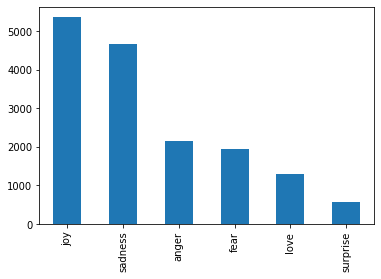

In [0]:
data = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")
data.emotion.value_counts().plot.bar()

In [0]:
train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [0]:
train.count()

text       16000
emotion    16000
dtype: int64

In [0]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:filelock:Lock 139955425093728 acquired on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpsnkx0l2g


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:filelock:Lock 139955425093728 released on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f

### Dataset

Here also we will process the examples in the same way we did above. If the label is 'love' we will ask the model to predict the text 'love'

Lets check how t5 encodes the following labels

In [0]:
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
for em in emotions:
  print(len(tokenizer.encode(em)))

1
1
1
1
1
1


Here also all the labels are encoded as single ids

In [0]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [0]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)
len(dataset)

2000

In [0]:
data = dataset[42]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i honestly don't feel discouraged today as i usually do
sadness


### Train

As I said above there's no need to change the model or add task specific head or any other hyperparameters, we'll just change the dataset and that's it!

In [0]:
!mkdir -p t5_emotion

In [0]:
args_dict.update({'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 2, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [0]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [0]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [0]:
model = T5FineTuner(args)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

In [0]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [0]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.0846, device='cuda:0')

INFO:__main__:loss = tensor(0.0290, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0290, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0846, device='cuda:0')



INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.5601, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.0696, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.0134, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0134, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0696, device='cuda:0')



1

### Eval

In [0]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [0]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [0]:
it = iter(loader)

In [0]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [0]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [0]:
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: i feel like ive come a long way and im proud of what ive achieved not only this week but this
year as well

Actual sentiment: joy
predicted sentiment: joy

text: i feel unfathomably rich in having had a healthy pregnancy so far

Actual sentiment: joy
predicted sentiment: joy

text: im just feeling emo and bitchy atm

Actual sentiment: anger
predicted sentiment: anger

text: i always feel troubled when we re on the road touring living in a van or more recently in the
circus buses no place to hang my hat as the song lyric has it

Actual sentiment: sadness
predicted sentiment: sadness

text: i still feel confused and guilty about the whole thing

Actual sentiment: fear
predicted sentiment: fear

text: i feel immensely distracted by the barrage of media i receive solicit

Actual sentiment: anger
predicted sentiment: anger

text: im feeling too tortured to write today

Actual sentiment: fear
predicted sentiment: anger

text: i have the joy of allowing kids to feel like the valued trea

#### Test Metrics

In [0]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

In [0]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')

In [0]:
metrics.accuracy_score(targets, outputs)

0.929

In [0]:
print(metrics.classification_report(targets, outputs))

              precision    recall  f1-score   support

       anger       0.94      0.93      0.93       275
        fear       0.86      0.92      0.89       224
         joy       0.97      0.93      0.95       695
        love       0.79      0.89      0.84       159
     sadness       0.97      0.96      0.97       581
    surprise       0.75      0.74      0.75        66

    accuracy                           0.93      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



Now lets plot  the confusion matrix and see for which classes our model is getting confused

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
cm = metrics.confusion_matrix(targets, outputs)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


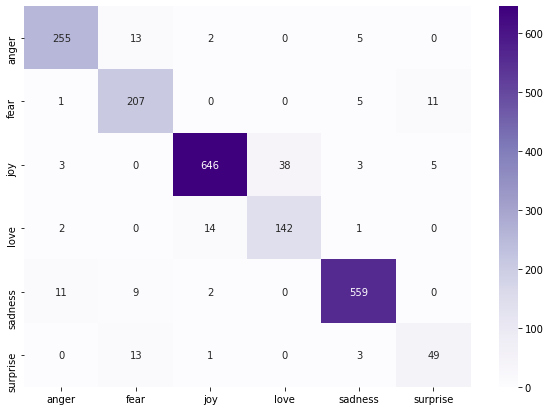

In [0]:
df_cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "love", "sadness", "surprise"], columns = ["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Purples', fmt='g')

From the above plot we can see that the most confused classes are 'joy' and 'love' which seems obivous as these two emotions are really close. We can say the same thing 'surprise' and 'anger' as well. So our model is doing pretty well.

## SWAG

Now lets try a more challenging task and see how it performs.

SWAG is a natural language inference and commonsense reasoning task proposed in this [paper](https://arxiv.org/pdf/1808.05326.pdf).

The basic task is that  a model is
given a context **c = (s, n)**: a complete sentence
**s** and a noun phrase **n** that begins a second sentence, as well as a list of possible verb phrase sentence endings **V**. The model must then
select the most appropriate verb phrase **v** in **V**. For example

On stage, a woman takes a seat at the piano. She

a) sits on a bench as her sister plays with the doll.

b) smiles with someone as the music plays.

c) is in the crowd, watching the dancers.

**d) nervously sets her fingers on the keys.**

The correct answer is bolded. Given the above example the model should select **nervously sets her fingers on the keys** as the most appropriate verb phrase

To frame this task in text-2-text setting the example is processed as below.

context: context_text options: 1: option_1 2: option_2 3: option_3 4: option_4

and if the actual label is 1 then the model is asked to predict the text '1'. Here's how the above example will be processed

**Input**

context: On stage, a woman takes a seat at the piano. She  options: 1: sits on a bench as her sister plays with the doll. 2: smiles with someone as the music plays. 3: is in the crowd, watching the dancers. 4: nervously sets her fingers on the keys.

**Target**

4

This is just one possible way to process these examples, there are various other ways we can formulate this problem in text-2-text setting but that's for later.

### Dataset

In [0]:
import csv
from dataclasses import dataclass

from enum import Enum
from typing import List, Optional
from transformers import PreTrainedTokenizer

In [0]:
!wget https://raw.githubusercontent.com/rowanz/swagaf/master/data/train.csv
!wget https://raw.githubusercontent.com/rowanz/swagaf/master/data/val.csv

!mkdir swag_data
!mv *.csv swag_data

--2020-05-09 15:06:34--  https://raw.githubusercontent.com/rowanz/swagaf/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28243333 (27M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  26.93M  35.9MB/s    in 0.8s    

2020-05-09 15:06:35 (35.9 MB/s) - ‘train.csv’ saved [28243333/28243333]

--2020-05-09 15:06:38--  https://raw.githubusercontent.com/rowanz/swagaf/master/data/val.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7893588 (7.5M) [text/plain]
Saving to: ‘val.csv’

val.cs

In [0]:
# below code is adapted from https://github.com/huggingface/transformers/blob/master/examples/multiple-choice/utils_multiple_choice.py

@dataclass(frozen=True)
class InputExample:
    """
    A single training/test example for multiple choice
    Args:
        example_id: Unique id for the example.
        question: string. The untokenized text of the second sequence (question).
        contexts: list of str. The untokenized text of the first sequence (context of corresponding question).
        endings: list of str. multiple choice's options. Its length must be equal to contexts' length.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """

    example_id: str
    context: str
    endings: List[str]
    label: Optional[str]

class Split(Enum):
    train = "train"
    dev = "dev"
    test = "test"

class DataProcessor:
    """Base class for data converters for multiple choice data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

class SwagProcessor(DataProcessor):
    """Processor for the SWAG data set."""

    def get_train_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {} train".format(data_dir))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "train.csv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {} dev".format(data_dir))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "val.csv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {} dev".format(data_dir))
        raise ValueError(
            "For swag testing, the input file does not contain a label column. It can not be tested in current code"
            "setting!"
        )
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test.csv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1", "2", "3"]

    def _read_csv(self, input_file):
        with open(input_file, "r", encoding="utf-8") as f:
            return list(csv.reader(f))

    def _create_examples(self, lines: List[List[str]], type: str):
        """Creates examples for the training and dev sets."""
        if type == "train" and lines[0][-1] != "label":
            raise ValueError("For training, the input file must contain a label column.")

        examples = [
            InputExample(
                example_id=line[2],
                # common beginning of each
                # choice is stored in "sent2".
                context=line[3],
                endings=[line[7], line[8], line[9], line[10]],
                label=line[11],
            )
            for line in lines[1:]  # we skip the line with the column names
        ]

        return examples

In [0]:
class SwagDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.data_dir = data_dir
    self.type_path = type_path
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self.proc = SwagProcessor()

    self._build()
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def __len__(self):
    return len(self.inputs)
  
  def _build(self):
    if self.type_path == 'train':
      examples = self.proc.get_train_examples(self.data_dir)
    else:
      examples = self.proc.get_dev_examples(self.data_dir)
    
    for example in examples:
      self._create_features(example)
  
  def _create_features(self, example):
    input_ = example.context
    options = ['%s: %s' % (i, option) for i, option in zip('1234', example.endings)]
    options = " ".join(options)
    input_ = "context: %s  options: %s </s>" % (input_, options)
    target = "%s </s>" % str(int(example.label) + 1)

    # tokenize inputs
    tokenized_inputs = self.tokenizer.batch_encode_plus(
        [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
    )
    # tokenize targets
    tokenized_targets = self.tokenizer.batch_encode_plus(
        [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
    )

    self.inputs.append(tokenized_inputs)
    self.targets.append(tokenized_targets)

In [0]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:filelock:Lock 140245777042344 acquired on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpv2ybakmg


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:filelock:Lock 140245777042344 released on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f

In [0]:
dataset = SwagDataset(tokenizer, data_dir='swag_data', type_path='val')
len(dataset)

INFO:__main__:LOOKING AT swag_data dev


20006

In [0]:
data = dataset[69]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

context: A little girl plays softly the drums holding two sticks while she is singing on a microphone. The, the girl options: 1: take in the greeting and an asian girl followed by two people standing on stage. 2: holds the microphone up and begins to girl dance an entire time. 3: claps the girls hands anxiously. 4: plays more fast the drums.
4


### Train

In [0]:
!mkdir -p t5_swag

In [0]:
args_dict.update({'data_dir': 'swag_data', 'output_dir': 't5_swag', 'num_train_epochs': 3})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'swag_data', 'output_dir': 't5_swag', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 3, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [0]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [0]:
def get_dataset(tokenizer, type_path, args):
  return SwagDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [0]:
model = T5FineTuner(args)

INFO:filelock:Lock 140242832534944 acquired on /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpwv74k3ig


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json in cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:filelock:Lock 140242832534944 released on /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165

INFO:filelock:Lock 140242971659568 acquired on /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa.lock
INFO:transformers.file_utils:https://cdn.huggingface.co/t5-base-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp5pcfx_u3


INFO:transformers.file_utils:storing https://cdn.huggingface.co/t5-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:filelock:Lock 140242971659568 released on /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa.lock
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/t5-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa


INFO:transformers.modeling_utils:Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [0]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [0]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

INFO:__main__:LOOKING AT swag_data train


INFO:__main__:LOOKING AT swag_data dev


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.3535, device='cuda:0')

INFO:__main__:loss = tensor(0.3080, device='cuda:0')

INFO:__main__:train_loss = tensor(0.3080, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3535, device='cuda:0')



INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.5107, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3268, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.5484, device='cuda:0')

INFO:__main__:train_loss = tensor(0.5484, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3268, device='cuda:0')

INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

### Eval

In [0]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [0]:
dataset =  SwagDataset(tokenizer, data_dir='swag_data', type_path='val')
loader = DataLoader(dataset, batch_size=32, num_workers=4)

INFO:__main__:LOOKING AT swag_data dev


In [0]:
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

In [0]:
for i, out in enumerate(outputs):
  if out not in "1234":
    print(i, 'detected invalid prediction')

In [0]:
metrics.accuracy_score(targets, outputs)

0.7397280815755274

This is great! We have achieved almost 74% accuracy with this simple formulation. This is great becuase with BERT like models to make a prediction on single example the model needs to do 4 forward passes, one for each possible endings and then the logits are concatenated together for all 4 passes and then passed through final softmax layer to produce 4 probabilities. This approach needs only a single pass for one example.